# A Particle Neural Network Toy Model for Jet Classification

Below are the import statements, as well as some self-built code modulas.

In [1]:
from MakeData import MakeData
from ParticleNet import ParticleNet
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from mpl_toolkits import mplot3d
import neural_structured_learning as nsl
from collections import defaultdict

The user decides the constant momentum used for this simulation for all particles, as well as the size of the training and testing data sets.  The actual size of the test and training data sets is doubled as these numbers are for each distribution. 

In [32]:
p = 100
Ntrain = 100
Ntest = 100

Here, I create the simulation data of a million particles per distribution for the training and testing data sets.

In [3]:
train,train_vals = MakeData(p,Ntrain)
test,test_vals = MakeData(p,Ntest)

Below is a 3D plot of the momentum of each particle.  Notice how all particles have constant total momentum but random direction, resulting in the data points filling out the surface of a sphere.

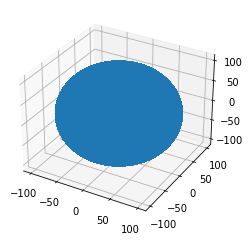

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(train[:,0], train[:,1], train[:,2]);

Below is a plot of the mass distributions for the training data set.  One expodential, one guassian.

(0.0, 400.0)

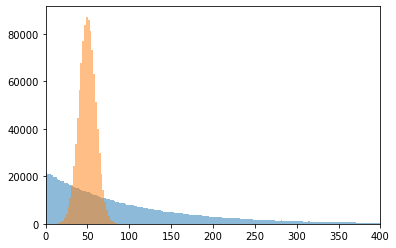

In [5]:
n,bins,weights = plt.hist(train[train_vals==0,3], bins = 'auto', alpha = 0.5)
plt.hist(train[train_vals==1,3], bins = bins, alpha = 0.5)
plt.xlim(0,400)

Here is a plot of Tau, the measure of N-subjettiness which is different for each mass distribution, and represented by a expodential distribution.

(0.0, 2500.0)

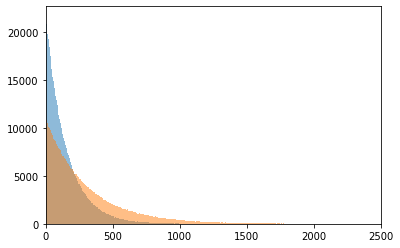

In [6]:
n,bins,weights = plt.hist(train[train_vals==0,4], bins = 'auto', alpha = 0.5)
plt.hist(train[train_vals==1,4], bins = bins, alpha = 0.5)
plt.xlim(0,2500)

Here, I show that the simulation data is shuffled before being fed into the neural networks.  This vector is of the true classifications of each particle, where 0 represents an expodential distribution and 1 a gaussian distribution.

In [7]:
print(test_vals[0:20])

[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.]


This line of code runs an ordinary neural network model.  The predictions for the test data set are returned.  These predictions are the probability guesses of the neural network for the test data set.  For each particle, the neural network will return a probability for each classification, two numbers in this case, one for the probability that particle is a 0, and another the probability this particle is a 1, representing expodential vs gaussian respectivly.

In [9]:
predictions = ParticleNet(train,train_vals,test,10)

Epoch 1/10
62500/62500 [==============================] - 33s 521us/step - loss: 0.4156 - accuracy: 0.8248
Epoch 2/10
62500/62500 [==============================] - 32s 512us/step - loss: 0.3349 - accuracy: 0.8553
Epoch 3/10
62500/62500 [==============================] - 33s 528us/step - loss: 0.3317 - accuracy: 0.8562
Epoch 4/10
62500/62500 [==============================] - 32s 512us/step - loss: 0.3290 - accuracy: 0.8575
Epoch 5/10
62500/62500 [==============================] - 33s 525us/step - loss: 0.3290 - accuracy: 0.8574
Epoch 6/10
62500/62500 [==============================] - 32s 519us/step - loss: 0.3288 - accuracy: 0.8571
Epoch 7/10
62500/62500 [==============================] - 229s 4ms/step - loss: 0.3283 - accuracy: 0.8577
Epoch 8/10
62500/62500 [==============================] - 36s 574us/step - loss: 0.3281 - accuracy: 0.8575
Epoch 9/10
62500/62500 [==============================] - 33s 525us/step - loss: 0.3276 - accuracy: 0.8581
Epoch 10/10
62500/62500 [=============

Here are the results of this ordinary neural network.  Accuracy is between 74% and 82% and the expodential data particles had a higher chance of being correctly classified than the guassian particles.

In [10]:
FalseExps = sum(predictions[np.where(test_vals == 0)])/Ntest*100
print("The model, on average, thought a Expodential distribution to be just that at " + str(FalseExps[0]) + " percent.")
print("And thought a Expodential distribution to be a Gaussian distribution at " + str(FalseExps[1]) + " percent.")
print("")
FalseGauss = sum(predictions[np.where(test_vals == 1)])/Ntest*100
print("The model, on average, thought a Gaussian distribution to be just that at " + str(FalseGauss[1]) + " percent.")
print("And thought a Gaussian distribution to be a Expodential distribution at " + str(FalseGauss[0]) + " percent.")

The model, on average, thought a Expodential distribution to be just that at 81.54463125 percent.
And thought a Expodential distribution to be a Gaussian distribution at 18.49735 percent.

The model, on average, thought a Gaussian distribution to be just that at 74.74608125 percent.
And thought a Gaussian distribution to be a Expodential distribution at 25.2595203125 percent.


# Base Model

This is the base model for the Adversarial Neural network, a completely different model then the one above.

In [11]:
def build_base_model():
    '''Builds the Basic Model'''
    input_shape = (1,1)
    inputs = [tf.keras.Input(shape=input_shape, dtype=tf.float32, name=name) for name in FEATURE_INPUT_NAME]
#    inputs = tf.keras.Input(shape=(5,))
    print(inputs)
    
    x = tf.keras.layers.concatenate(inputs = [*inputs], axis=-1, name = 'concat')

    
    print(x)
    
    x = tf.keras.layers.Conv1D(64, 3, padding = 'same', activation='relu', name = 'conv1')(x)
    x = tf.keras.layers.Conv1D(64, 1, padding = 'same', activation='relu', name = 'conv2')(x)
#    x = tf.keras.layers.MaxPool1D(2)(x)
    x = tf.keras.layers.Conv1D(32, 3, padding = 'same', activation='relu', name = 'conv3')(x)
    x = tf.keras.layers.Conv1D(32, 1, padding = 'same', activation='relu', name = 'conv4')(x)
#    x = tf.keras.layers.MaxPool1D(2)(x)
    x = tf.keras.layers.Flatten(name = 'flatten')(x)
    x = tf.keras.layers.Dense(64, activation='relu', name = 'relu')(x)
    pred = tf.keras.layers.Dense(2, activation='softmax', name = 'output')(x) 
    model = tf.keras.Model(inputs=[*inputs], outputs=pred)

    return model

Below the base model is built and a summary of its layers are printed out.

In [12]:
FEATURE_INPUT_NAME = ['Px','Py','Pz','Mass','Tau']
base_model = build_base_model()
base_model.summary()

[<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Px')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Py')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Pz')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Mass')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Tau')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None), name='concat/concat:0', description="created by layer 'concat'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Px (InputLayer)                 [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
Py (InputLayer)                 [(None, 1, 1)]       0                  

Here, I train the base model with the same training data set used above.

In [13]:
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

base_model.fit((train[:,0],train[:,1],train[:,2],train[:,3],train[:,4]),train_vals, epochs=10)

Epoch 1/10
62500/62500 [==============================] - 67s 1ms/step - loss: 0.3356 - acc: 0.8518
Epoch 2/10
62500/62500 [==============================] - 65s 1ms/step - loss: 0.3213 - acc: 0.8594
Epoch 3/10
62500/62500 [==============================] - 64s 1ms/step - loss: 0.3209 - acc: 0.8594
Epoch 4/10
62500/62500 [==============================] - 58s 930us/step - loss: 0.3189 - acc: 0.8605
Epoch 5/10
62500/62500 [==============================] - 59s 939us/step - loss: 0.3191 - acc: 0.8605
Epoch 6/10
62500/62500 [==============================] - 58s 925us/step - loss: 0.3191 - acc: 0.8604
Epoch 7/10
62500/62500 [==============================] - 57s 918us/step - loss: 0.3197 - acc: 0.8600
Epoch 8/10
62500/62500 [==============================] - 61s 981us/step - loss: 0.3195 - acc: 0.8604
Epoch 9/10
62500/62500 [==============================] - 6761s 108ms/step - loss: 0.3190 - acc: 0.8608
Epoch 10/10
62500/62500 [==============================] - 63s 1ms/step - loss: 0.3196

# Adversarial Model

Now, the adversarial model is outlined.

In [14]:
base_adv_model = build_base_model()
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys = ['labels']
)

[<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Px')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Py')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Pz')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Mass')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Tau')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None), name='concat/concat:0', description="created by layer 'concat'")


Here, I am just reformating the training and testing data sets such that they can be input into the adversarial model.

In [29]:
trainAdv = {
    'Px': train[:,0],
    'Py': train[:,1],
    'Pz': train[:,2],
    'Mass': train[:,3],
    'Tau': train[:,4],
    'labels': train_vals
}

testAdv = {
    'Px': test[:,0],
    'Py': test[:,1],
    'Pz': test[:,2],
    'Mass': test[:,3],
    'Tau': test[:,4],
    'labels': test_vals
}

Here, I compile the adversarial model.

In [30]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

And here, I fit the adversarial model to the training data set.

In [31]:
adv_model.fit(trainAdv, epochs=1)

62500/62500 [==============================] - 99s 2ms/step - loss: 0.3833 - sparse_categorical_crossentropy: 0.3194 - sparse_categorical_accuracy: 0.8606 - scaled_adversarial_loss: 0.0639


This is the summary of the Adversarial Regularization model.

In [23]:
adv_model.summary()

Model: "AdversarialRegularization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2)                 14658     
Total params: 14,658
Trainable params: 14,658
Non-trainable params: 0
_________________________________________________________________


Below, the accuracy of the Adversarial model on the test data set is evaulated.

In [19]:
results = adv_model.evaluate(testAdv)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

62500/62500 [==============================] - 61s 967us/step - loss: 0.3841 - sparse_categorical_crossentropy: 0.3200 - sparse_categorical_accuracy: 0.8609 - scaled_adversarial_loss: 0.0640

accuracy: 0.8608800172805786


And here, the predictions for the adversarial model on the test data set are calculated.  Just as before, these predictions are the probability guesses of the neural network for the test data set.  For each particle, the neural network will return a probability for each classification, two numbers in this case, one for the probability that particle is a 0, and another the probability this particle is a 1, representing expodential vs gaussian respectivly.

In [20]:
predict = adv_model.predict(testAdv)

Here are the results of the adversarial neural network on the test data set.  Accuracy is between 77% and 81% and the expodential data particles had a higher chance of being correctly classified than the guassian particles.

In [21]:
FalseExps = sum(predict[np.where(test_vals == 0)])/Ntest*100
print("The model, on average, thought a Expodential distribution to be just that at " + str(FalseExps[0]) + " percent.")
print("And thought a Expodential distribution to be a Gaussian distribution at " + str(FalseExps[1]) + " percent.")
print("")
FalseGauss = sum(predict[np.where(test_vals == 1)])/Ntest*100
print("The model, on average, thought a Gaussian distribution to be just that at " + str(FalseGauss[1]) + " percent.")
print("And thought a Gaussian distribution to be a Expodential distribution at " + str(FalseGauss[0]) + " percent.")

The model, on average, thought a Expodential distribution to be just that at 80.708325 percent.
And thought a Expodential distribution to be a Gaussian distribution at 19.3184484375 percent.

The model, on average, thought a Gaussian distribution to be just that at 77.65648125 percent.
And thought a Gaussian distribution to be a Expodential distribution at 22.352840625 percent.


## Summary of Results

Below is a summary of the results from both neural networks.  Both have around the same accuracy for the test data set of between 74% and 82% accuracy.  However, the adversarial neural network has a smaller range of values for the correct predictions, a range spaning 3% between the two distributions being correctly predicted, as opposed to the normal neural network having a range of 7% accuracy between correctly predicting a expodential vs a guassian distribution.

In [22]:
FalseExps = sum(predictions[np.where(test_vals == 0)])/Ntest*100
print("Ordinary Neural Network:")
print("The model, on average, thought a Expodential distribution to be just that at " + str(FalseExps[0]) + " percent.")
print("And thought a Expodential distribution to be a Gaussian distribution at " + str(FalseExps[1]) + " percent.")
FalseGauss = sum(predictions[np.where(test_vals == 1)])/Ntest*100
print("The model, on average, thought a Gaussian distribution to be just that at " + str(FalseGauss[1]) + " percent.")
print("And thought a Gaussian distribution to be a Expodential distribution at " + str(FalseGauss[0]) + " percent.")
print("")
print("Advesarial Neural Network:")
FalseExps = sum(predict[np.where(test_vals == 0)])/Ntest*100
print("The model, on average, thought a Expodential distribution to be just that at " + str(FalseExps[0]) + " percent.")
print("And thought a Expodential distribution to be a Gaussian distribution at " + str(FalseExps[1]) + " percent.")
FalseGauss = sum(predict[np.where(test_vals == 1)])/Ntest*100
print("The model, on average, thought a Gaussian distribution to be just that at " + str(FalseGauss[1]) + " percent.")
print("And thought a Gaussian distribution to be a Expodential distribution at " + str(FalseGauss[0]) + " percent.")

Ordinary Neural Network:
The model, on average, thought a Expodential distribution to be just that at 81.54463125 percent.
And thought a Expodential distribution to be a Gaussian distribution at 18.49735 percent.
The model, on average, thought a Gaussian distribution to be just that at 74.74608125 percent.
And thought a Gaussian distribution to be a Expodential distribution at 25.2595203125 percent.

Advesarial Neural Network:
The model, on average, thought a Expodential distribution to be just that at 80.708325 percent.
And thought a Expodential distribution to be a Gaussian distribution at 19.3184484375 percent.
The model, on average, thought a Gaussian distribution to be just that at 77.65648125 percent.
And thought a Gaussian distribution to be a Expodential distribution at 22.352840625 percent.


(0.0, 200.0)

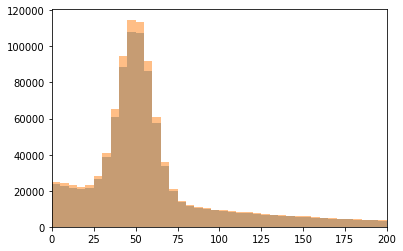

In [25]:
dist = train[:,3]*predict[:,0]
plt.hist(x=train[:,3],weights=predict[:,1],alpha=0.5, bins=np.arange(0,1000,5))
plt.hist(x=train[:,3],weights=predict[:,0],alpha=0.5, bins=np.arange(0,1000,5))
plt.xlim(0,200)

In [36]:
adv_model.get_weights()

[array([[[-1.23591825e-01,  9.83715355e-02, -1.23316742e-01,
           9.12475586e-03,  7.18389750e-02,  1.40926987e-01,
           6.77518994e-02,  1.01317883e-01, -7.27292597e-02,
          -1.57961950e-01,  1.51794761e-01, -5.02071008e-02,
           7.69457221e-03,  1.16324246e-01, -1.02321737e-01,
           1.09974623e-01,  1.42854065e-01,  3.89840007e-02,
          -4.37585115e-02, -1.28593013e-01,  1.25390738e-01,
          -1.59619540e-01,  1.02474451e-01, -1.28571466e-01,
          -5.76144829e-02,  2.77712792e-02, -5.57457954e-02,
          -1.66462451e-01,  7.41958171e-02, -2.36884654e-02,
          -3.71434391e-02,  9.99318957e-02,  1.65068358e-01,
          -5.47244400e-02, -1.37985229e-01, -1.59410492e-01,
           8.60860944e-02,  1.17733210e-01,  4.73625958e-02,
           1.53988928e-01,  1.11699402e-01,  1.67972654e-01,
          -4.94048148e-02,  1.81561857e-02,  1.60121411e-01,
           1.56888783e-01, -8.41396973e-02, -7.77611360e-02,
          -7.12808892e-0